In [1]:
# Change working directory to the notebook's parent directory
import os
os.chdir(os.path.dirname(os.path.abspath("../jupyter_notebooks/Visualization.ipynb")))
print(f"Current working directory: {os.getcwd()}")

Current working directory: /workspaces/mildew-detector/jupyter_notebooks


# Data Visualization
This notebook contains visualizations for the cherry leaves dataset. All generated plots and files will be saved in the '../out/visualization/' directory.

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure output directory exists
output_dir = '../out/visualization'
os.makedirs(output_dir, exist_ok=True)
print(f'Visualization output directory: {output_dir}')

Visualization output directory: ../out/visualization


## Interactive Image Montage: Healthy vs. Powdery Mildew Cherry Leaves

This section provides an interactive montage to visually compare healthy and diseased cherry leaves, supporting the business need for visual differentiation. Use the dropdown to select a class and scroll through sample images.

Output()

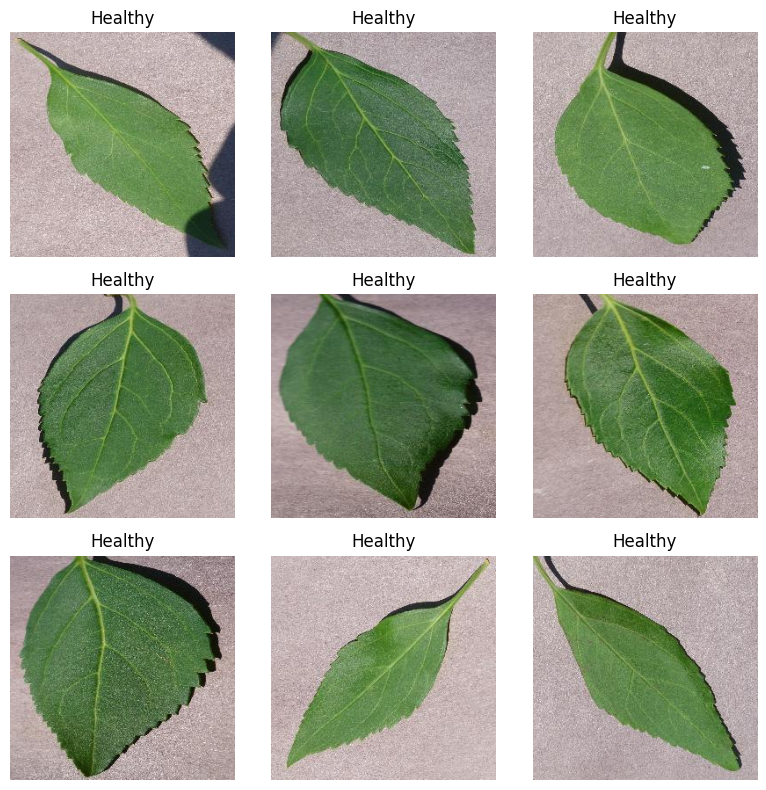

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from glob import glob
from PIL import Image
import random

# Directories for both classes
healthy_dir = '../data/cherry-leaves/healthy'
mildew_dir = '../data/cherry-leaves/powdery_mildew'

# Get image file paths
healthy_images = glob(os.path.join(healthy_dir, '*.JPG'))
mildew_images = glob(os.path.join(mildew_dir, '*.JPG'))

def show_images(class_name, n=9):
    if class_name == 'Healthy':
        imgs = random.sample(healthy_images, min(n, len(healthy_images)))
    else:
        imgs = random.sample(mildew_images, min(n, len(mildew_images)))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for ax, img_path in zip(axes.flatten(), imgs):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(class_name)
    for ax in axes.flatten()[len(imgs):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

dropdown = widgets.Dropdown(options=['Healthy', 'Powdery Mildew'], value='Healthy', description='Class:')
button = widgets.Button(description='Show New Samples')

output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output(wait=True)
        show_images(dropdown.value)

button.on_click(on_button_clicked)

display(widgets.HBox([dropdown, button]))
display(output)
show_images(dropdown.value)

## Class Distribution and Dataset Overview

Understanding the distribution of healthy and powdery mildew images is important for model development and business insights. The following cell visualizes the class balance in the dataset.

In [4]:
# Plot class distribution and print summary statistics
class_counts = {'Healthy': len(healthy_images), 'Powdery Mildew': len(mildew_images)}
plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.title('Class Distribution in Cherry Leaves Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.tight_layout()
plt.show()

print('Summary Statistics:')
for cls, count in class_counts.items():
    print(f'{cls}: {count} images')

/tmp/ipykernel_9853/2350244832.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


Summary Statistics:
Healthy: 2104 images
Powdery Mildew: 2104 images


In [8]:
# --- Self-contained: Show example predictions and ROC curve without external notebook dependencies ---
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc

# Set up test data directory and parameters
split_base = '../data/split'
img_size = (224, 224)
batch_size = 18

# Prepare test generator
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
    directory=split_base,
    target_size=img_size,
    batch_size=batch_size,
    classes=['healthy', 'powdery_mildew'],
    class_mode='binary',
    shuffle=False,
    seed=42,
    color_mode='rgb',
)

# Load trained model
model_path = '../out/modeling/best_model.keras'
best_model = load_model(model_path)

# Get predictions and true labels
test_image_paths = test_generator.filepaths
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
y_pred_probs = best_model.predict(test_generator, verbose=0).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Show a grid of 12 random test images with predictions
n_show = 12
indices = np.random.choice(len(test_image_paths), n_show, replace=False)
plt.figure(figsize=(16, 8))
for i, idx in enumerate(indices):
    img = Image.open(test_image_paths[idx])
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color = 'green' if y_true[idx] == y_pred[idx] else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')
plt.suptitle('Example Predictions (Red = Misclassified)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Plot ROC curve and calculate AUC ---
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Found 6144 images belonging to 2 classes.


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
